In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

接着我们初始化行人状态x, 行人的不确定性（协方差矩阵）P，测量的时间间隔dt，处理矩阵F以及测量矩阵H：

In [5]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

dt = 0.1 # Time Step between Filter Steps
F = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(F, F.shape)

H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)
[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


计算测量过程的噪声的协方差矩阵R和处理噪声的协方差矩阵Q：

In [16]:
ra = 0.09
R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

sv = 0.5
G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
Q = G*G.T*sv**2

[[0.09 0.  ]
 [0.   0.09]] (2, 2)


In [17]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T

⎡       4         4        3        3⎤
⎢0.25⋅dt   0.25⋅dt   0.5⋅dt   0.5⋅dt ⎥
⎢                                    ⎥
⎢       4         4        3        3⎥
⎢0.25⋅dt   0.25⋅dt   0.5⋅dt   0.5⋅dt ⎥
⎢                                    ⎥
⎢      3         3       2        2  ⎥
⎢0.5⋅dt    0.5⋅dt      dt       dt   ⎥
⎢                                    ⎥
⎢      3         3       2        2  ⎥
⎣0.5⋅dt    0.5⋅dt      dt       dt   ⎦

定义一个单位矩阵：

In [7]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


随机产生一些测量数据：

(2, 200)
Standard Deviation of Acceleration Measurements=0.97
You assumed 0.09 in R.


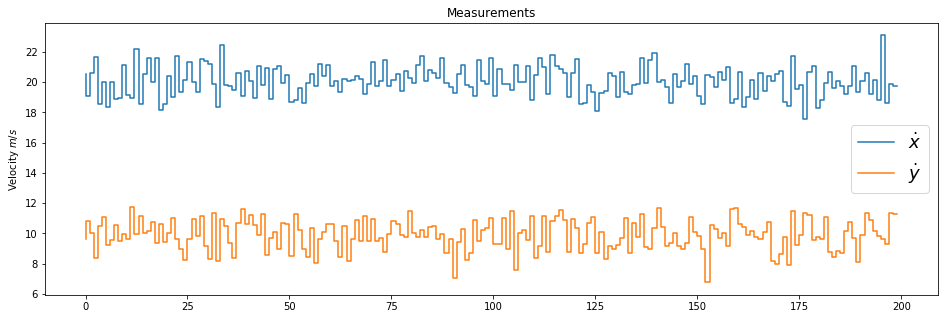

In [9]:
m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))
measurements = np.vstack((mx,my))

print(measurements.shape)
print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

fig = plt.figure(figsize=(16,5))
plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

一些过程值，用于结果的显示

In [10]:
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

卡尔曼滤波：

In [12]:
for n in range(len(measurements[0])):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = F*x

    # Project the error covariance ahead
    P = F*P*F.T + Q

    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*H))*P

    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

显示一下关于速度的估计结果：

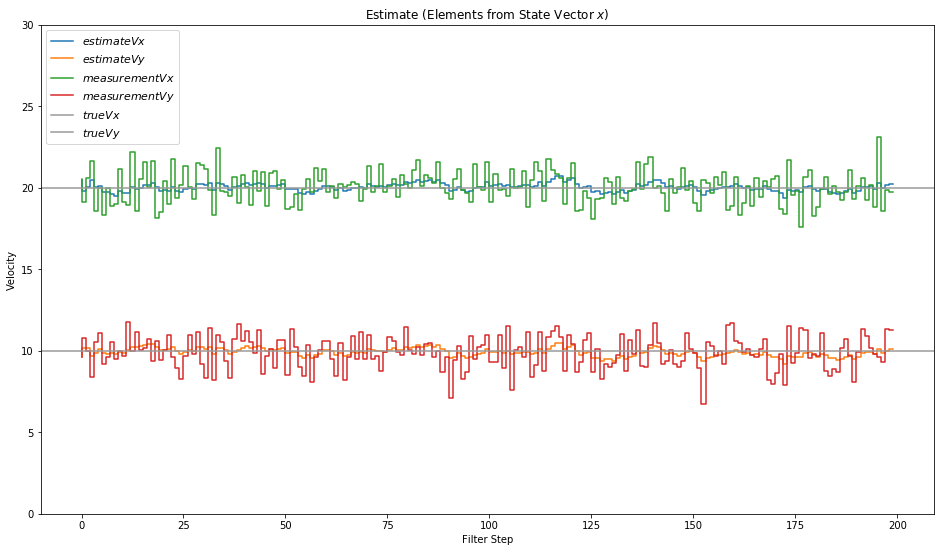

In [14]:
def plot_x():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])),dxt, label='$estimateVx$')
    plt.step(range(len(measurements[0])),dyt, label='$estimateVy$')

    plt.step(range(len(measurements[0])),measurements[0], label='$measurementVx$')
    plt.step(range(len(measurements[0])),measurements[1], label='$measurementVy$')

    plt.axhline(vx, color='#999999', label='$trueVx$')
    plt.axhline(vy, color='#999999', label='$trueVy$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':11})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')
plot_x()

位置的估计结果：

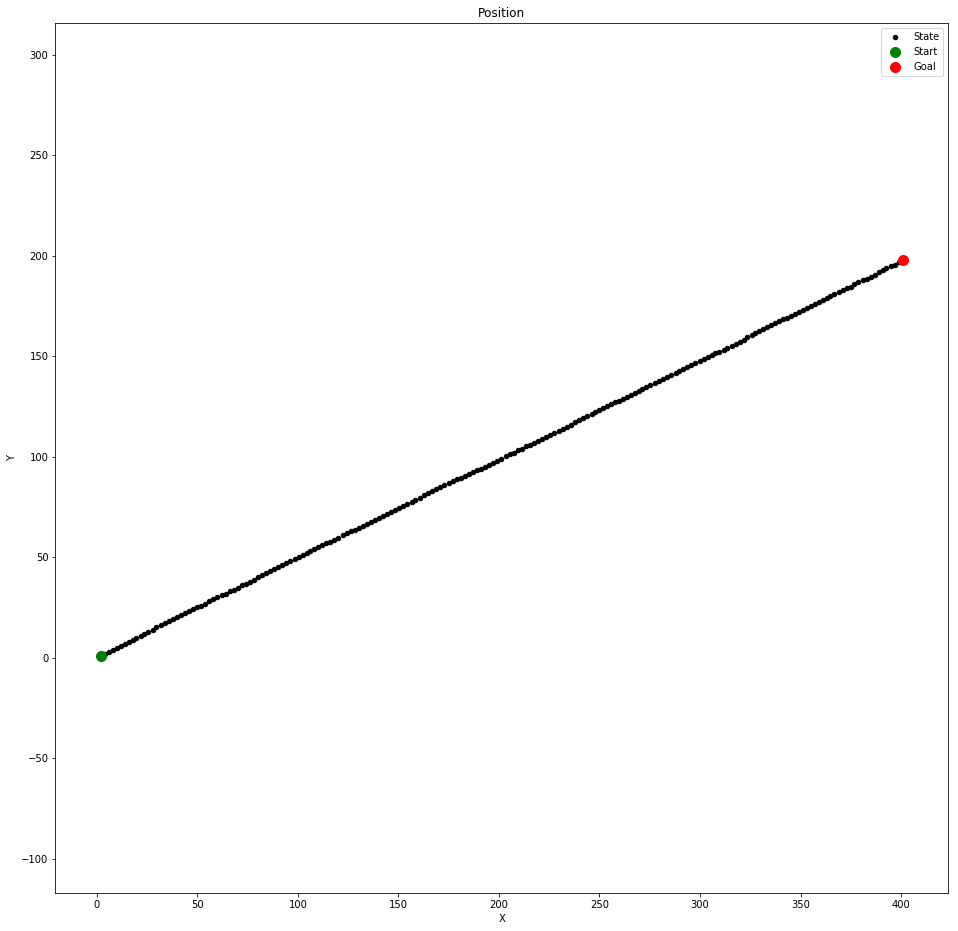

In [15]:
def plot_xy():
    fig = plt.figure(figsize=(16,16))
    plt.scatter(xt,yt, s=20, label='State', c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
plot_xy()